#**PROBLEMA EMPRESARIAL**

Una empresa de retial busca realizar el pronóstico de sus ventas para mejorar la cadena de suministro o de logística. Para ello, se cuenta con base de datos de ventas desde el 2015 al 2023.

**Objetivo del análsis:**
Utilizar series de tiempo para predecir las ventas en futuros meses.

**Base de datos:**

**Ventas:** valor de ventas totales en la tienda.

**Meses:** fecha de ventas

**Gasto en publicidad:** valor gastado en publicidad

**Feriado:** variable dummy para indicar mes de Diciembre o mes con altas ventas)


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


In [ ]:
# Generate synthetic time series data
np.random.seed(42)
date_range = pd.date_range(start='2015-01-01', end='2023-12-31', freq='M')
data = 100 + np.sin(2 * np.pi * date_range.month / 12) * 10 + np.random.normal(0, 5, len(date_range))
time_series = pd.DataFrame({'Date': date_range, 'Sales': data})
time_series.set_index('Date', inplace=True)

# Adding exogenous variables
np.random.seed(42)
time_series['Advertising_Spend'] = 50 + np.random.normal(0, 5, len(date_range))  # Simulating advertising spend
time_series['Holidays_Dummy'] = (time_series.index.month == 12).astype(int)  # Holidays dummy variable


<ipython-input-9-1134ca92fc1b>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2015-01-01', end='2023-12-31', freq='M')


In [ ]:
time_series.describe()

,Sales,Advertising_Spend,Holidays_Dummy
count,108.000000,108.000000,108.000000
mean,99.487864,49.487864,0.083333
std,7.854550,4.542539,0.277674
min,81.401901,36.901274,0.000000
25%,93.341607,46.995472,0.000000
50%,99.890449,49.251125,0.000000
75%,105.538631,51.913931,0.000000
max,116.483472,59.430930,1.000000


from matplotlib import pyplot as plt
_df_0['Sales'].plot(kind='hist', bins=20, title='Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Advertising_Spend'].plot(kind='hist', bins=20, title='Advertising_Spend')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Holidays_Dummy'].plot(kind='hist', bins=20, title='Holidays_Dummy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Sales', y='Advertising_Spend', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Advertising_Spend', y='Holidays_Dummy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Sales'].plot(kind='line', figsize=(8, 4), title='Sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Advertising_Spend'].plot(kind='line', figsize=(8, 4), title='Advertising_Spend')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Holidays_Dummy'].plot(kind='line', figsize=(8, 4), title='Holidays_Dummy')
plt.gca().spines[['top', 'right']].set_visible(False)

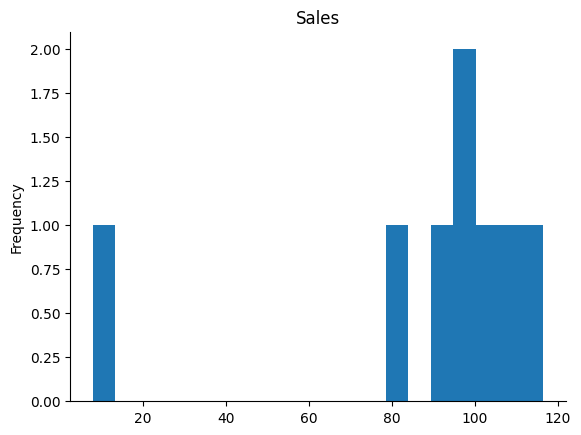

In [ ]:
from matplotlib import pyplot as plt
_df_0['Sales'].plot(kind='hist', bins=20, title='Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

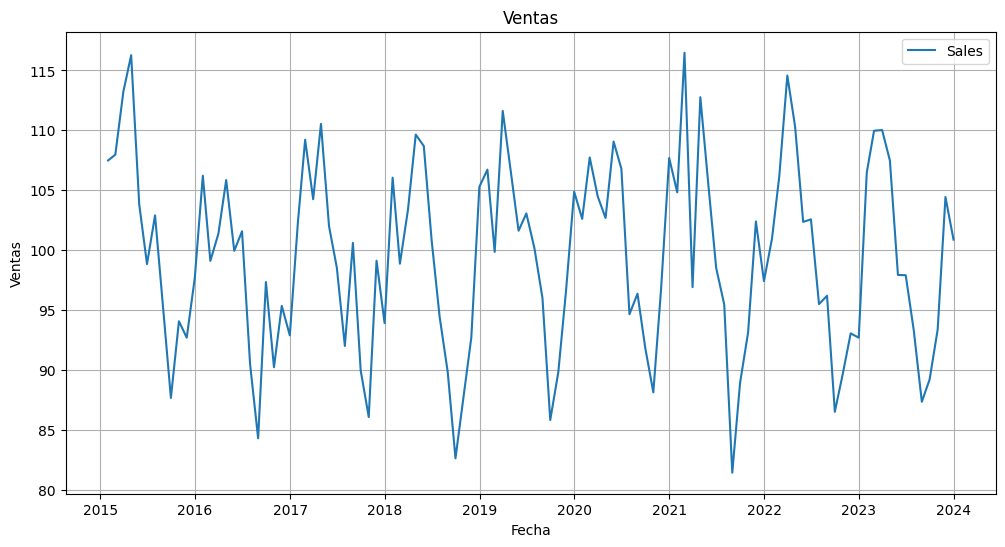

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(time_series['Sales'], label="Sales")
plt.title("Ventas")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid()
plt.show()

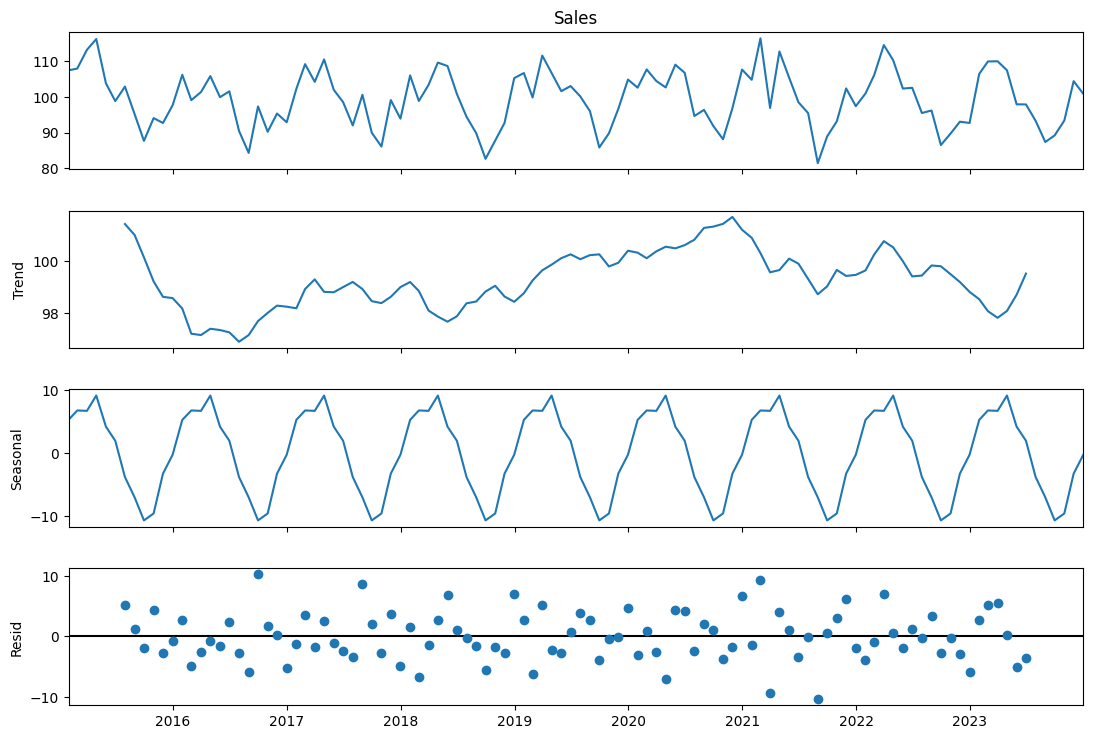

In [ ]:
# Seasonal decomposition
decomposition = seasonal_decompose(time_series['Sales'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

El **panel superior** representa los datos reales observados (ventas) a lo largo del tiempo. Esto incluye todas las variaciones debidas a la tendencia, la estacionalidad y el ruido residual.
Tendencia:

El **segundo panel muestra la tendencia** a largo plazo de los datos, que es la trayectoria suavizada de las ventas a lo largo del tiempo.
Por ejemplo, si las ventas aumentan, disminuyen o se mantienen estables en general, esto se reflejaría aquí.
Estacional:

El **tercer panel captura patrones o ciclos recurrentes a intervalos fijos** (por ejemplo, mensuales o anuales).
En este caso, muestra fluctuaciones periódicas claras que se repiten cada 12 meses, lo que indica una marcada estacionalidad en las ventas.
Residual (ruido):

El panel inferior muestra lo que queda después de **eliminar la tendencia y la estacionalidad de los datos observados.**
Esto representa variaciones o irregularidades aleatorias que no se explican por la tendencia o la estacionalidad.

**INSIGHTS:**

**Estacionalidad marcada:** patrones claros que se repiten cada 12 meses (por ejemplo, las ventas navideñas aumentan en diciembre).

**Tendencia estable:** el componente de tendencia muestra cambios graduales en el nivel general de ventas a lo largo de los años.

**Ruido residual:** los residuos son relativamente pequeños y están dispersos alrededor de cero, lo que indica que la tendencia y la estacionalidad capturan efectivamente la mayor parte de la estructura de los datos.

<Figure size 1200x600 with 0 Axes>

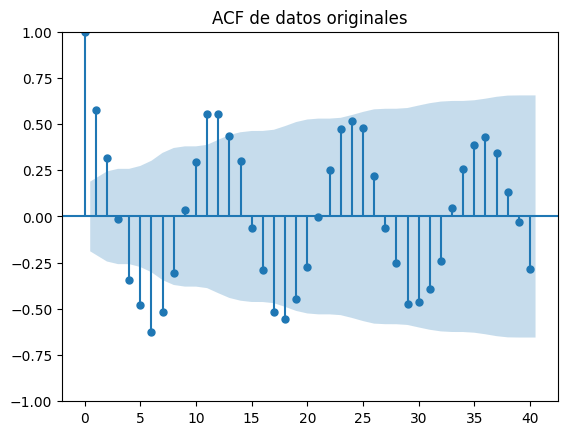

<Figure size 1200x600 with 0 Axes>

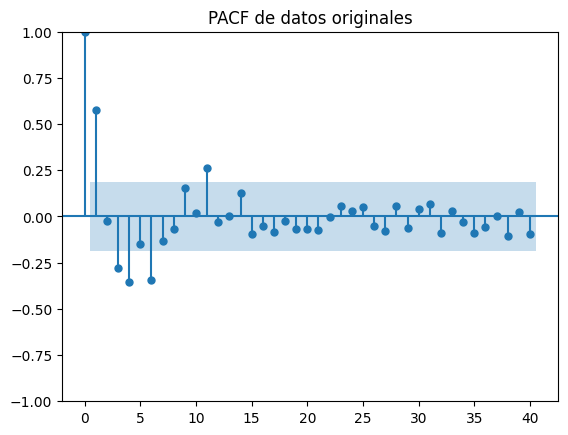

In [ ]:
# ACF and PACF for Original Data
plt.figure(figsize=(12, 6))
plot_acf(time_series['Sales'], lags=40, title="ACF de datos originales")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(time_series['Sales'], lags=40, title="PACF de datos originales")
plt.show()

In [ ]:
# Train-Test Split
train = time_series[:'2022']['Sales']
test = time_series['2023':]['Sales']
exog_train = time_series.loc[:'2022', ['Advertising_Spend', 'Holidays_Dummy']]
exog_test = time_series.loc['2023':, ['Advertising_Spend', 'Holidays_Dummy']]

In [ ]:
# ARIMA Model
arima_model = ARIMA(train, order=(2, 1, 2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


**Un modelo ARIMA tiene tres componentes clave:**

**AR (Autorregresivo):** determina cómo los valores pasados ​​(rezagos) influyen en el valor actual. El parámetro p=2 especifica que el modelo utiliza los dos últimos rezagos de la serie temporal.

p=2: Dos términos autorregresivos basados ​​en el gráfico PACF, donde aparecen picos significativos en el desfase 1 y disminuyen después del desfase 2.

**I (Integración):** especifica la cantidad de pasos de diferenciación necesarios para que la serie sea estacionaria. Aquí, d=1 indica que la serie temporal se diferencia una vez.

d=1: Un paso de diferenciación basado en la tendencia observada en la serie temporal original y la autocorrelación significativa en el desfase 1 en el gráfico ACF.

**MA (Promedio móvil):** modela el término de error (residuos) como una función de los errores de pronóstico pasados. El parámetro q=2 utiliza los dos últimos rezagos de los errores.

q=2: Dos términos de promedio móvil basados ​​en el gráfico ACF, donde aparecen correlaciones significativas en el desfase 1 y el desfase 2.


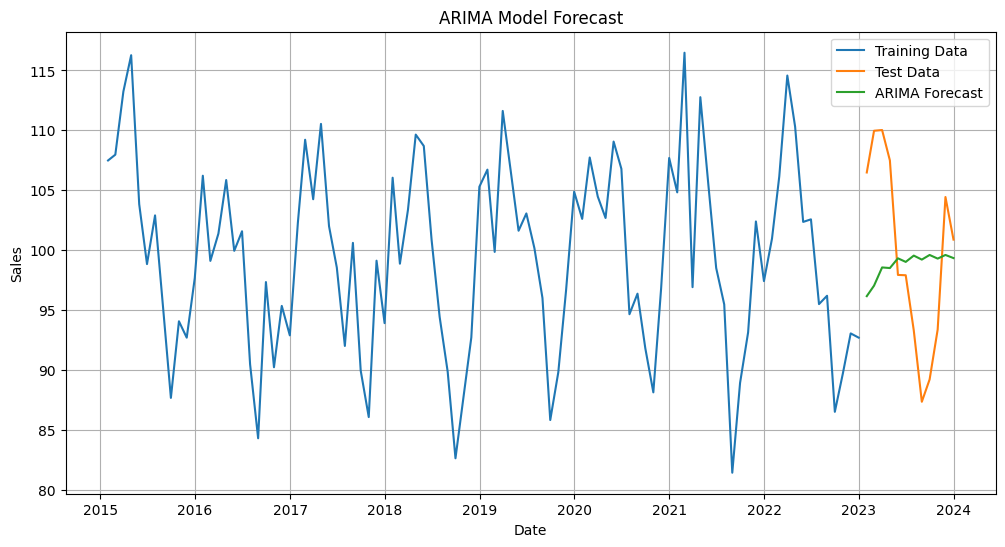

In [ ]:
# Plot ARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

El modelo ARIMA captura la tendencia general y algunas de las fluctuaciones en los datos de entrenamiento razonablemente bien, como se espera para un modelo ARIMA(2, 1, 2).

**Pronóstico en el período de prueba:**

El pronóstico **no captura completamente las fluctuaciones estacionales** visibles
en los datos de prueba (línea naranja). Esto se debe a que ARIMA no tiene en cuenta los patrones estacionales explícitos.

La línea verde muestra menos variabilidad en comparación con los datos de prueba, lo que sugiere que el modelo captura principalmente la tendencia e ignora la fuerte estacionalidad presente en los datos.
Limitaciones:

**Se ignora la estacionalidad:** el fuerte patrón estacional (p. ej., picos y valles de ventas cada 12 meses) evidente en la descomposición y los gráficos ACF/PACF no está modelado, lo que genera discrepancias entre los datos de prueba y el pronóstico.

**Subpredicción/Sobrepredicción:** Los valores pronosticados subestiman el pico y sobreestiman el valle en los datos de ventas para el período de prueba.

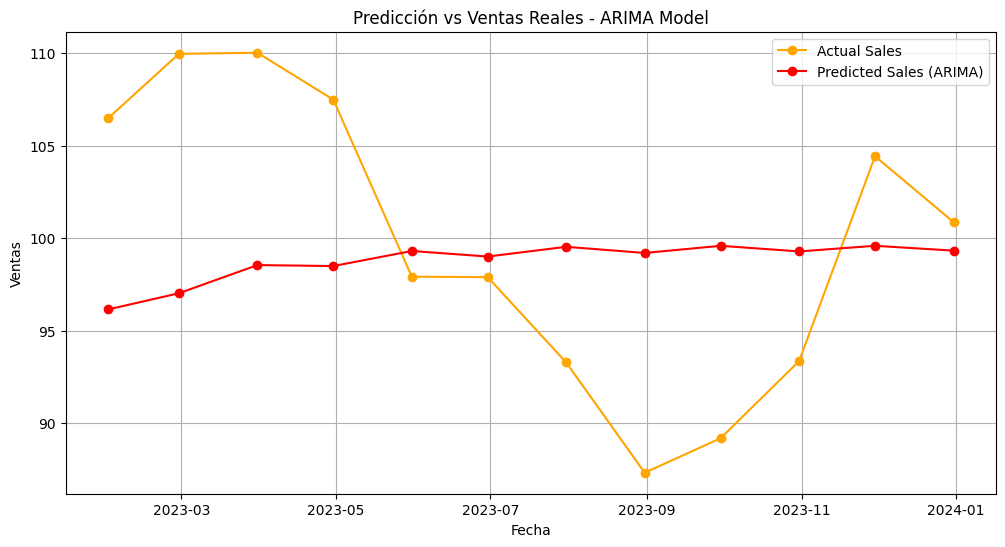

In [ ]:
# Plot Predicted vs Actual Values for the Test Period
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Sales", marker='o', color='orange')
plt.plot(test.index, arima_forecast, label="Predicted Sales (ARIMA)", marker='o', color='red')
plt.title("Predicción vs Ventas Reales - ARIMA Model")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


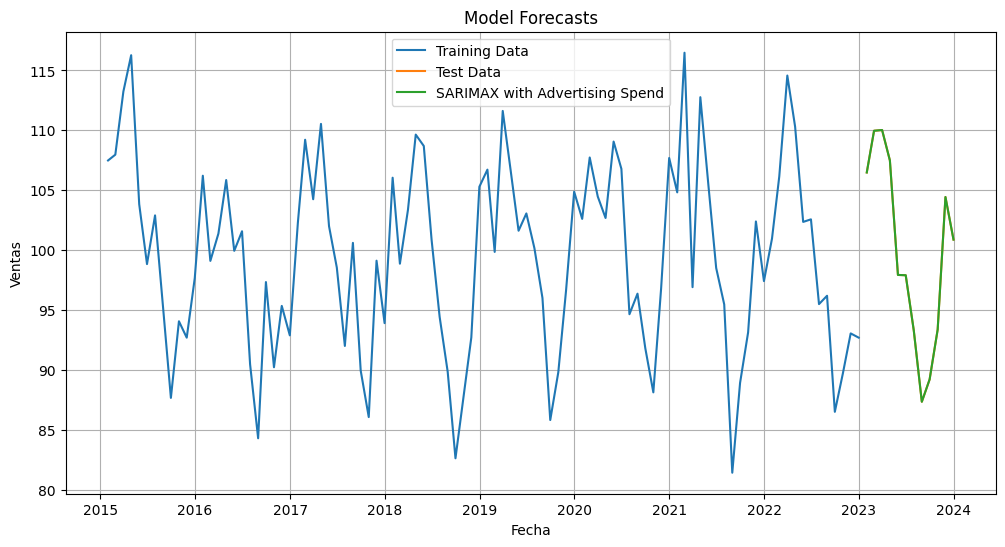

In [ ]:
# SARIMAX Model con una variable exógena
sarimax_exog1_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12),
                              exog=exog_train['Advertising_Spend'])
sarimax_exog1_result = sarimax_exog1_model.fit()
sarimax_exog1_forecast = sarimax_exog1_result.forecast(steps=len(test), exog=exog_test['Advertising_Spend'])

# Plotting SARIMAX forecasts
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data")
plt.plot(test.index, sarimax_exog1_forecast, label="SARIMAX with Advertising Spend")
plt.title("Model Forecasts")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid()
plt.show()


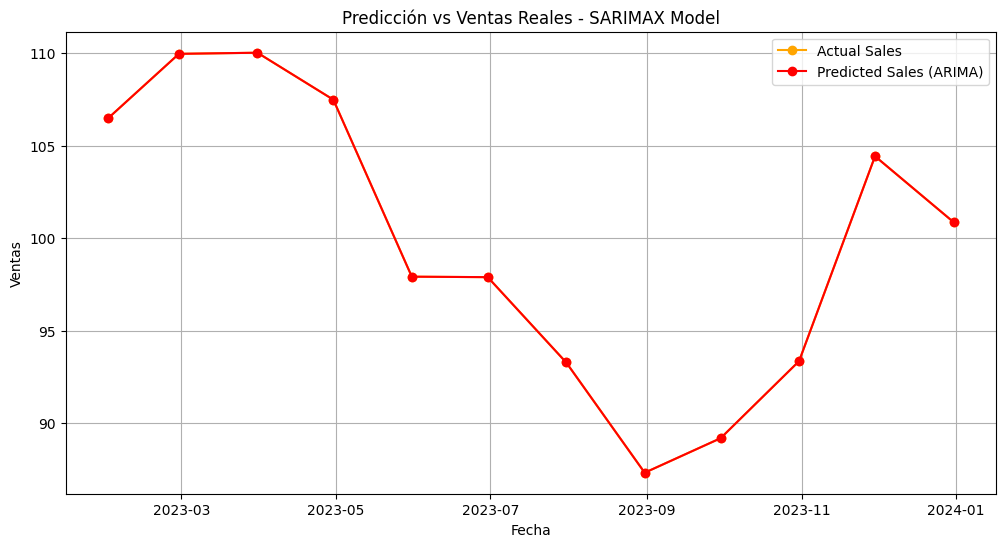

In [ ]:
# Plot Predicted vs Actual Values for the Test Period
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Sales", marker='o', color='orange')
plt.plot(test.index, sarimax_exog1_forecast, label="Predicted Sales (ARIMA)", marker='o', color='red')
plt.title("Predicción vs Ventas Reales - SARIMAX Model")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


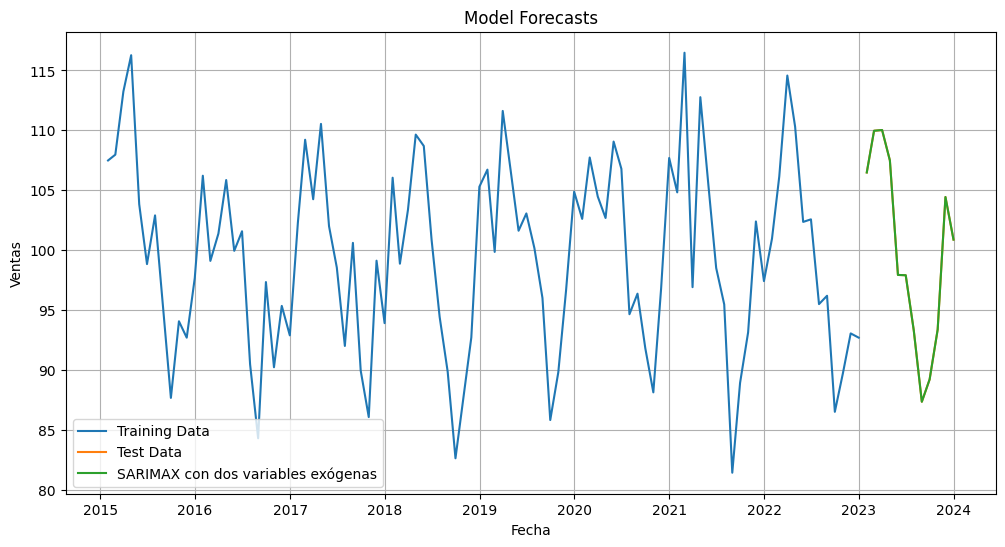

In [ ]:
# SARIMAX Model con dos variables exógenas
sarimax_exog2_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12),
                              exog=exog_train)
sarimax_exog2_result = sarimax_exog2_model.fit()
sarimax_exog2_forecast = sarimax_exog2_result.forecast(steps=len(test), exog=exog_test)

# Plotting SARIMAX forecasts
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data")
plt.plot(test.index, sarimax_exog2_forecast, label="SARIMAX con dos variables exógenas")
plt.title("Model Forecasts")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Model Comparison
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = sqrt(mean_squared_error(test, arima_forecast))

sarimax_exog1_mae = mean_absolute_error(test, sarimax_exog1_forecast)
sarimax_exog1_rmse = sqrt(mean_squared_error(test, sarimax_exog1_forecast))

sarimax_exog2_mae = mean_absolute_error(test, sarimax_exog2_forecast)
sarimax_exog2_rmse = sqrt(mean_squared_error(test, sarimax_exog2_forecast))

comparison = pd.DataFrame({
    "Model": ["ARIMA", "SARIMAX with Advertising Spend", "SARIMAX with Two Exogenous Variables"],
    "MAE": [arima_mae, sarimax_exog1_mae, sarimax_exog2_mae],
    "RMSE": [arima_rmse, sarimax_exog1_rmse, sarimax_exog2_rmse]
})

print("Model Comparison:")
print(comparison)

Model Comparison:
                                  Model           MAE          RMSE
0                                 ARIMA  7.255779e+00  8.361280e+00
1        SARIMAX with Advertising Spend  5.447494e-14  1.603582e-13
2  SARIMAX with Two Exogenous Variables  9.828932e-07  1.041930e-06
